# NTDS'18 milestone 1: network collection and properties
[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `4`
* Students: `Julien Berger, Jérémy Jayet, Hana Samet, Mathieu Shiva`
* Dataset: `IMDb Films and Crew `

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to three sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective 

The purpose of this milestone is to start getting acquainted to the network that you will use for this class. In the first part of the milestone you will import your data using [Pandas](http://pandas.pydata.org) and you will create the adjacency matrix using [Numpy](http://www.numpy.org). This part is project specific. In the second part you will have to compute some basic properties of your network. **For the computation of the properties you are only allowed to use the packages that have been imported in the cell below.** You are not allowed to use any graph-specific toolboxes for this milestone (such as networkx and PyGSP). Furthermore, the aim is not to blindly compute the network properties, but to also start to think about what kind of network you will be working with this semester. 

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import queue as Q # Package used to manage queues
import logging

logging.basicConfig(level=logging.ERROR)

## Part 1 - Import your data and manipulate them. 

###  A. Load your data in a Panda dataframe.

First, you should define and understand what are your nodes, what features you have and what are your labels. Please provide below a Panda dataframe where each row corresponds to a node with its features and labels. For example, in the the case of the Free Music Archive (FMA) Project, each row of the dataframe would be of the following form:


| Track   |  Feature 1  | Feature 2 | . . . | Feature 518|  Label 1 |  Label 2 |. . .|Label 16|
|:-------:|:-----------:|:---------:|:-----:|:----------:|:--------:|:--------:|:---:|:------:|
|         |             |           |       |            |          |          |     |        |

It is possible that in some of the projects either the features or the labels are not available. This is OK, in that case just make sure that you create a dataframe where each of the rows corresponds to a node and its associated features or labels.

In [2]:
#When the flag is set to 0 the feature dataframe is created from the initial dataset
#When the flag is set to 1, the feature dataframe is loaded from a file
#This avoids to compute the feature dataframe each time that we reload the kernel
flag_features=1


#Create the features from the original dataset
if flag_features==0:
    # The flattening of the data was achieved by using the code provided alongsided the dataset on kaggle 
    # The following section is simply the application of the following method :
    #  https://www.kaggle.com/sohier/tmdb-format-introduction/notebook
    #########################################################################################################################
    #########################################################################################################################
    movies = pd.read_csv('./data/tmdb_5000_movies.csv')
    movies['release_date'] = pd.to_datetime(movies['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        movies[column] = movies[column].apply(json.loads)

    credits = pd.read_csv('./data/tmdb_5000_credits.csv')
    json_columns = ['cast', 'crew']
    for column in json_columns:
           credits[column] = credits[column].apply(json.loads)

    #give a new movie index to replace the current movie index
    new_movie_index=np.arange(movies.shape[0])  
    movies['id']=new_movie_index
    credits['movie_id']=new_movie_index  

    def safe_access(container, index_values):
        # return a missing value rather than an error upon indexing/key failure
        result = container
        try:
            for idx in index_values:
                result = result[idx]
            return result
        except IndexError or KeyError:
            return pd.np.nan

    credits.apply(lambda row: [x.update({'movie_id': row['movie_id']}) for x in row['cast']], axis=1);
    credits.apply(lambda row: [x.update({'movie_id': row['movie_id']}) for x in row['crew']], axis=1);
    credits.apply(lambda row: [person.update({'order': order}) for order, person in enumerate(row['crew'])], axis=1);

    cast = []
    credits.cast.apply(lambda x: cast.extend(x))
    cast = pd.DataFrame(cast)
    cast['type'] = 'cast'

    crew = []
    credits.crew.apply(lambda x: crew.extend(x))
    crew = pd.DataFrame(crew)
    crew['type'] = 'crew'

    people = pd.concat([cast, crew],  ignore_index=True, sort=False)
    #########################################################################################################################
    #########################################################################################################################

    #The rest of the section is our own code.

    #Removing the useless columns and sorting the data by the unique ID of each person
    people = people.drop(columns=['gender','department', 'credit_id','cast_id', 'job','order','character','type'])
    people = people.sort_values(by='id')

    #removing the rows with similar person and ID (For example if someone played 2 different roles in a movie we only keep one of these entries)
    people=people.drop_duplicates(subset=['id', 'movie_id'])

    #get the number of movie that each person worked on
    table_nb_movies=people['id'].value_counts()
    unique_values=people['id'].unique()

    movies['movie_id']=movies['id']
    movies=movies.drop(columns=['vote_count','budget','genres','homepage','keywords','original_language','overview','popularity','production_companies','production_countries','release_date','revenue','runtime','spoken_languages','status','tagline','original_title'])
    movies = movies.set_index('movie_id')

    #merge the movies and the people so that we can get the rating of each movie 
    people = people.merge(movies, on='movie_id')
    people['id']=people['id_x']
    people = people.drop(columns=['id_x','id_y'])

    #simple_list will contain all the different actor names, this will be the column of our features
    simple_list=people.loc[:, ['id','movie_id','name']]
    simple_list=simple_list.sort_values(by='id')
    simple_list=simple_list.drop_duplicates('id')
    simple_list=simple_list.set_index('id') 
    simple_list=simple_list.drop(columns=['movie_id'])

    #This code takes 14 minutes to run and removes all the people that worked on less than 5 movies
    #This subsampling of the dataset is done to go from 104'000 nodes to only 9628
    threshold_movies=5
    for idx in unique_values:
        nb_films=table_nb_movies[idx] 
        if (nb_films)<threshold_movies:
            simple_list=simple_list.drop(index=idx)

    #Calculate the number of people that did more than 5 movies
    unique_id=simple_list['id'].unique()
    unique_id.sort()

    #Add a column that will contain the average rating of the actor 
    simple_list['Average_Rating']=np.nan

    #Add one colum for all the existing movies
    for i in new_movie_index:
        simple_list['Movie_ID_%d' % i]=0

    unique_id=simple_list['id'].unique()
    unique_id.sort()
    index_ini=0

    #This code adds a 1 in the corresponding movie column of simple_list if the person worked in this movie  
    #It also calculates the average rating of all the movies the person worked on and adds it in the AVERAGE_RATING column
    for idx in unique_id:
        rating_average=0
        subset=people[people['id'] == idx]
        new_index_subset = pd.Series(range(0,len(subset)))
        subset=subset.set_index(new_index_subset) 
        index_person=subset.iloc[0,4]

        for i in new_index_subset:
            index_film=subset.iloc[i-1,0]+3
            #simple_list.loc[idx, 'Movie_ID_%d' % index_film]=1
            simple_list.iloc[index_ini, index_film]=1
            rating_average=rating_average+subset.iloc[i-1,3]
        rating_average=rating_average/len(subset)
            #simple_list.loc[idx, 'Average_Rating']=rating_average
        simple_list.iloc[index_ini, 2]=rating_average
        index_ini=index_ini+1

    #This simple_list is now our feature dataframe that contains a row for each node (the people),
    # a column for each movie of the dataset that
    features=simple_list
    
#load the features from a file
if flag_features==1:
    features = pd.read_csv('./data/features.csv') 
    features = features.drop(features.columns[0],axis=1)
    features = features.drop(columns=['name'],axis=1)
    
features

,id,Average_Rating,Movie_ID_0,Movie_ID_1,Movie_ID_2,Movie_ID_3,Movie_ID_4,Movie_ID_5,Movie_ID_6,Movie_ID_7,...,Movie_ID_4793,Movie_ID_4794,Movie_ID_4795,Movie_ID_4796,Movie_ID_4797,Movie_ID_4798,Movie_ID_4799,Movie_ID_4800,Movie_ID_4801,Movie_ID_4802
0,1,6.955556,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,6.634375,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,6.218750,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,7.437500,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,7.328571,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,8,7.357143,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,10,7.425000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,13,6.614286,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,18,6.146154,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,19,6.417241,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### B. Create the adjacency matrix of your network.

Remember that there are edges connecting the attributed nodes that you organized in the dataframe above. The connectivity of the network is captured by the adjacency matrix $W$. If $N$ is the number of nodes, the adjacency matrix is an $N \times N$ matrix where the value of $W(i,j)$ is the weight of the edge connecting node $i$ to node $j$.  

There are two possible scenarios for your adjacency matrix construction, as you already learned in the tutorial by Benjamin:

1) The edges are given to you explicitly. In this case you should simply load the file containing the edge information and parse it in order to create your adjacency matrix. See how to do that in the  [graph from edge list]() demo.

2) The edges are not given to you. In that case you will have to create a feature graph. In order to do that you will have to chose a distance that will quantify how similar two nodes are based on the values in their corresponding feature vectors. In the [graph from features]() demo Benjamin showed you how to build feature graphs when using Euclidean distances between feature vectors. Be curious and explore other distances as well! For instance, in the case of high-dimensional feature vectors, you might want to consider using the cosine distance. Once you compute the distances between your nodes you will have a fully connected network. Do not forget to sparsify by keeping the most important edges in your network.

Follow the appropriate steps for the construction of the adjacency matrix of your network and provide it in the Numpy array ``adjacency`` below: 

In [3]:
#When the flag is set to 0 the adjacency matrix dataframe is created from the feature matrix
#When the flag is set to 1, the adjency matrix is loaded from a file
#This avoids to compute the feature dataframe each time that we reload the kernel
flag_adjacency=1

#we save the columns of the feature dataframe that contain the id and the average rating so that we can
#only keep a binary matrix that links people to the movies they worked on
backup_id=features['id']
backup_rating=features['Average_Rating']

#Create the adjacency matrix from the feature dataframe
if flag_adjacency==0:
    
    #We calculate the number of nodes   
    n_nodes=len(features)
    
    #Create a matrix of 0 of size 9628x9628 (the number of nodes)
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
    features = features.drop(columns=['id','Average_Rating'],axis=1)
    
    for idx_mul in range(n_nodes):
        #for each different people, multiply his feature row to the entire matrix and stock this in a temporary array
        tmp=features.multiply(features.iloc[idx_mul])
        #On each row of the adjacency matrix, sum all the values of this temporary array
        adjacency[idx_mul]=tmp.sum(axis=1)
    
    #fill the diagonal of the matrix with zeroes
    np.fill_diagonal(adjacency, 0)
    
#load the adjacency matrix from a file  
if flag_adjacency==1:
    adjacency = np.load('./data/adjacency.npy')
    
    #We calculate the number of nodes   
    n_nodes=adjacency.shape[0]


#We make the matrix more sparse by removing the link between two people if they worked only on 1 movie together
adjacency[adjacency <2]=0

## Part 2

Execute the cell below to plot the (weighted) adjacency matrix of your network.

Text(0.5, 1.05, 'adjacency matrix')

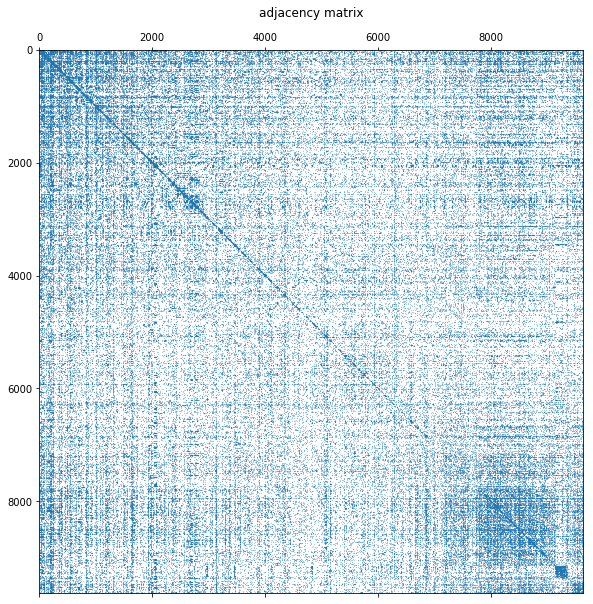

In [4]:
plt.figure(figsize=(10, 10))
plt.spy(adjacency, markersize=0.1)
plt.title('adjacency matrix')

### Question 1

What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your network)? How many links $L$ are there in your collected network? Comment on the sparsity of your network.

In [5]:
# Number of links in our network:
L = np.count_nonzero(adjacency)/2 ;
L

130613.0

Considering a fully connected undirected network with N nodes, the maximum number of links (Lmax) would be N*(N-1)/2.

### Question 2

Is your graph directed or undirected? If it is directed, convert it to an undirected graph by symmetrizing the adjacency matrix.

Our graph is *undirected*.

In [6]:
# No code as the graph is undirected

### Question 3

In the cell below save the features dataframe and the **symmetrized** adjacency matrix. You can use the Pandas ``to_csv`` to save the ``features`` and Numpy's ``save`` to save the ``adjacency``. We will reuse those in the following milestones.

In [7]:
#No need to save them each time

#features.to_csv('./data/features_backup.csv', sep=','); 
#np.save('./data/adjacency_backup', adjacency);

### Question 4

Are the edges of your graph weighted?

Yes.

### Question 5

What is the degree distibution of your network? 

In [8]:
unweighted_adjacency=adjacency
unweighted_adjacency[unweighted_adjacency != 0] = 1;
degree = np.sum(unweighted_adjacency, axis=0); # Your code here. It should be a numpy array.

assert len(degree) == n_nodes

Execute the cell below to see the histogram of the degree distribution.

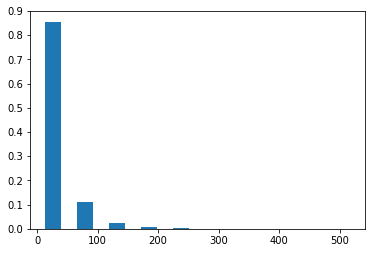

In [9]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights, rwidth=.5);

What is the average degree?

In [10]:
average = np.mean(degree)
average

27.131906938097217

### Question 6

Comment on the degree distribution of your network.

There is a big portion of our nodes (around 85%) that have a rather small number of degrees. However we can also see that there is also a few nodes with a much bigger number of degrees that could probably suggest the existance of a giant component.

### Question 7

Write a function that takes as input the adjacency matrix of a graph and determines whether the graph is connected or not.

In [11]:
def connected_graph(adjacency):
    """Determines whether a graph is connected.

    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.

    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """
    # Init connected
    connected = False

    # Creates a node list with the number nodes contained in the adjacency matrix
    nodeList = adjacency.shape
    nodeList = nodeList[0]
    nodeList = np.full(nodeList, np.nan)

    # Initialize a queue
    queueBuffer = Q.Queue()

    # Initialize an array containing all the indexes of all the non-zero elements connecting the the 0 node with the others
    connectedNodesTo0 = np.nonzero(adjacency[0,:])

    # Init the queue
    for i in np.nditer(connectedNodesTo0):
        queueBuffer.put(i)

    # Test each node if they are connected
    #
    # 1. Get the node in the queue and the distance from the source of the previous node.
    # 2. If the node has not been assigned a distance yet, assign it the distance of the previous node + 1.
    # 3. Get all the connected nodes and put them in the queue.
    # 4. When there is no more nodes in the queue, exit the loop.
    #
    while queueBuffer.empty() == False :
        node = queueBuffer.get()
        tmp = np.nonzero(adjacency[node,:])
        for j in np.nditer(tmp):
            if np.isnan(nodeList[j]):
                nodeList[j] = 1
                queueBuffer.put(j)

    nbOfConnectedNodes = np.nansum(nodeList)
    nbOfExpectedConnectedNodes = nodeList.size

    if nbOfConnectedNodes == nbOfExpectedConnectedNodes :
        connected = True
    else :
        connected = False

    return connected

Is your graph connected? Run the ``connected_graph`` function to determine your answer.

In [12]:
connected_graph(adjacency)

False

### Question 8

Write a function that extracts the connected components of a graph.

In [13]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    #initializing the array used to store the indices of nodes in each connected component 
    connectedIndices = np.zeros((adjacency.shape[0],adjacency.shape[0]))
    
    #array used to keep track of the visited nodes (NaN = not visited):
    nodeList = np.full(adjacency.shape[0], np.nan)
    
    #initializing a queue to store connected nodes
    queueBuffer = Q.Queue()
    
  
    
    for i in range(adjacency.shape[0]):
        if np.isnan(nodeList[i]):
            #if the node has no connections to the other nodes
            if sum(adjacency[i,:]) == 0:
                connectedIndices[i,i] = 1
                nodeList[i] = 1
            else:
                #initializing the connections of node i
                connectionsToI = np.nonzero(adjacency[i,:])
                
                #We will add to queue the nodes connected to the first not visited (=NaN) node in nodeList 
                for k in np.nditer(connectionsToI):
                    queueBuffer.put(k)
                
                #extracting all the nodes that have a path to node i
                while queueBuffer.empty() == False:
                    node = queueBuffer.get()
                    tmp = np.nonzero(adjacency[node,:])
                    for j in np.nditer(tmp):
                        if np.isnan(nodeList[j]):
                            nodeList[j] = 1
                            queueBuffer.put(j)
                    
                    if i == 0:
                        connectedIndices[i,:]=nodeList
                    else:
                        connectedIndices[i,:]=nodeList-np.nansum(connectedIndices, axis=0)
   
    #converting NaN values to zeros:
    connectedIndices=np.nan_to_num(connectedIndices)
    
    #deleting zero lines:
    connectedIndices = connectedIndices[~(connectedIndices==0).all(1)]
    
    #Now let's build a 3D matrix with the adjecency matrices of each connected componnent
    
    n_components = connectedIndices.shape[0] #number of total connected components, including isolated nodes
    #components = np.zeros((n_components,adjacency.shape[0],adjacency.shape[0]))    

    return connectedIndices

How many connected components is your network composed of? What is the size of the largest connected component? Run the ``find_components`` function to determine your answer. 

In [14]:
connectedIndices = find_components(adjacency)

biggestComponentSize = np.amax(np.sum(connectedIndices, axis=1))
print(f'The biggest component contains {biggestComponentSize} nodes.')
nbOfComponents = connectedIndices.shape[0]
print(f'There are {nbOfComponents} in the graph')

The biggest component contains 9276.0 nodes.
There are 343 in the graph


### Question 9

Write a function that takes as input the adjacency matrix and a node (`source`) and returns the length of the shortest path between that node and all nodes in the graph using Dijkstra's algorithm. **For the purposes of this assignment we are interested in the hop distance between nodes, not in the sum of weights. **

Hint: You might want to mask the adjacency matrix in the function ``compute_shortest_path_lengths`` in order to make sure you obtain a binary adjacency matrix. 

In [15]:
def compute_shortest_path_lengths(adjacency, source):
    """Compute the shortest path length between a source node and all nodes.

    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.

    Returns
    -------
    list of ints
        The length of the shortest path from source to all nodes. Returned list
        should be of length n_nodes.
    """

    # Creates a node list with the number of nodes contained in the adjacency
    # matrix
    nodeList = adjacency.shape
    nodeList = nodeList[0]
    nodeList = np.full(nodeList, np.nan)

    # Set the distance of the source node to 0
    nodeList[source] = 0

    # Initialize a queue
    queueBuffer = Q.SimpleQueue()

    # Initialize an array containing all the indexes of all the non-zero
    # elements connecting the the 0 node with the others
    connectedNodesToSource = np.nonzero(adjacency[source,:])

    logging.debug(f'These nodes are connected to {source} : {connectedNodesToSource[0]}')

    # Init the queue and set the distances of the adjacent nodes
    # (to the source) to 1
    if connectedNodesToSource[0].size != 0:
        for i in np.nditer(connectedNodesToSource):
            nodeList[i] = 1
            queueBuffer.put(i)
    else:
        logging.warning(f'There is no node connected to {source}')
        return nodeList

    # Iterate over the nodes and calculate their distance
    while queueBuffer.empty() == False :
        node = queueBuffer.get() # Get the node in the queue
        tmp = np.nonzero(adjacency[node,:]) # Get a list of the connected nodes
        for j in np.nditer(tmp): # Iterate over the connected nodes
            if np.isnan(nodeList[j]): # Eliminate the ones that are already been processed
                nodeList[j] = nodeList[node]+1 # Add, for each node, their distance to the source node using the distance of the parent node
                queueBuffer.put(j) # Place it in the queue

    shortest_path_lengths = np.array(nodeList, np.int32)
    return shortest_path_lengths

### Question 10

The diameter of the graph is the length of the longest shortest path between any pair of nodes. Use the above developed function to compute the diameter of the graph (or the diameter of the largest connected component of the graph if the graph is not connected). If your graph (or largest connected component) is very large, computing the diameter will take very long. In that case downsample your graph so that it has 1.000 nodes. There are many ways to reduce the size of a graph. For the purposes of this milestone you can chose to randomly select 1.000 nodes. 

In [16]:
def compute_diameter(adjacency,nbOfSamples=1000):

    # Init diameter
    diameter = 0

    # Get the number of nodes
    nbOfNodes = (adjacency.shape)[0]

    # Init an nparray to contain all the length between nodes
    shortest_path_lengths = np.zeros(nbOfNodes, np.int32)

    # Make a sampling of the nodes but if the number of samples exceed the
    # number of nodes, keep the list of nodes.
    if nbOfSamples >= nbOfNodes:
        samples = range(0,nbOfNodes)
    else:
        samples = np.random.randint(0,nbOfNodes,(nbOfSamples))

    logging.info(f'nbOfNodes = {nbOfNodes}')
    logging.info(f'nbOfSamples = {nbOfSamples}')

    # Compute the distance for each node in the list between itself and all the
    # other nodes
    for i in samples:
        logging.info(f'Testing node {i} and diameter = {diameter}')

        shortest_path_lengths = compute_shortest_path_lengths(adjacency, i)
        maxVal = np.amax(shortest_path_lengths)
        if maxVal > diameter:
            diameter = maxVal

    return diameter

diameter = compute_diameter(adjacency)
print(f'The largest component of our graph has a diameter equal to {diameter}')

/home/jeremy/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


The largest component of our graph has a diameter equal to 10


### Question 11

Write a function that takes as input the adjacency matrix, a path length, and two nodes (`source` and `target`), and returns the number of paths of the given length between them.

In [17]:
def compute_paths(adjacency, source, target, length):
    """Compute the number of paths of a given length between a source and target node.

    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    target: int
        The target node. A number between 0 and n_nodes-1.
    length: int
        The path length to be considered.

    Returns
    -------
    int
        The number of paths.
    """

    n_paths = 0
    node = source
    nodeDist = 0

    # Creates a node list with the number nodes contained in the adjacency matrix
    nbOfNodes = (adjacency.shape)[0]

    # Initialize a queue
    queueBuffer = Q.Queue()

    # Init the queue
    queueBuffer.put((source, 0))

    # Test the case where source == target
    if source == target :
        n_paths = 0
        return n_paths

    # 1. Get the node in the queue and its distance from the source
    # 2. Find the adjacent nodes
    # 3. Test if the adjacent nodes are the target node and at a good distance
    #   - If *yes*, continue to the next node in the list
    #   - If *no*, but you are at a good distance, continue to the next node
    #       in the list without incrementing the path counter
    #   - Else, juste add the node in the queue for further process
    while queueBuffer.empty() == False :
        (node,nodeDist) = queueBuffer.get()

        tmp = np.nonzero(adjacency[node,:])
        for j in np.nditer(tmp):
            if j == target and (nodeDist+1) == length :
                n_paths = n_paths + 1
                continue
            elif (nodeDist+1) == length :
                continue
            else:
                queueBuffer.put((j,nodeDist+1))

    return n_paths

Test your function on 5 pairs of nodes, with different lengths.

In [18]:
print(compute_paths(adjacency, 0, 10, 1))
print(compute_paths(adjacency, 0, 10, 2))
print(compute_paths(adjacency, 0, 10, 3))
print(compute_paths(adjacency, 23, 67, 2))
print(compute_paths(adjacency, 15, 93, 4))

0
0
1
1
1331


### Question 12

How many paths of length 3 are there in your graph? Hint: calling the `compute_paths` function on every pair of node is not an efficient way to do it.

In [19]:
print(np.sum(np.linalg.matrix_power(adjacency,3)))

1582421582


### Question 13

Write a function that takes as input the adjacency matrix of your graph (or of the largest connected component of your graph) and a node and returns the clustering coefficient of that node. 

In [20]:
def compute_clustering_coefficient(adjacency, node):
    """Compute the clustering coefficient of a node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    node: int
        The node whose clustering coefficient will be computed. A number between 0 and n_nodes-1.
    
    Returns
    -------
    float
        The clustering coefficient of the node. A number between 0 and 1.
    """
    
    adjacency[adjacency !=0]=1 #masking to get the unweighted matrix 
    clustering_coefficient=0
    idx_neighbours=np.nonzero(adjacency[node])  #get the indices of the neighbours
    number_neighbours=idx_neighbours[0].size    #get the number of neighbours
    
    if number_neighbours<2: #if only 0 or 1 neighbour, the clustering coefficient is equal to 0
           return 0 
    
    #For all neighbours, see if they have links between them
    for j in range(number_neighbours):
        idx_test=idx_neighbours[0][j]
        nb_similar_neighbours=adjacency[node]*adjacency[idx_test]
        clustering_coefficient=clustering_coefficient+sum(nb_similar_neighbours)
    
    clustering_coefficient=clustering_coefficient/(number_neighbours*(number_neighbours-1))
    #no need to multiply by 2 because we already count each link twice
    
    return clustering_coefficient

### Question 14

What is the average clustering coefficient of your graph (or of the largest connected component of your graph if your graph is disconnected)? Use the function ``compute_clustering_coefficient`` to determine your answer.

In [21]:
average_clustering_coeff=0

#Use the previous function on each node of the graph and take the average
for i in range (n_nodes):
    tmp=compute_clustering_coefficient(adjacency, i)
    average_clustering_coeff=average_clustering_coeff+tmp
    
average_clustering_coeff=average_clustering_coeff/n_nodes
average_clustering_coeff # 0.3558

0.35578062088367507